
# ISPY2
## View ISPY2 data snd model  with nifti files
#### Author: Itamar Barnea
#### Date: 2025-03-2
> BreastDCEDL/SPY2/modeling_ispy2_with_nifti_files.ipynb

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/naomifridman/BreastDCEDL/blob/main/modeling_ispy2_with_nifti_files.ipynb)

# I SPY-2 Dataset Directory Structure

The I SPY-2 dataset contains breast cancer MRI data organized into two main directories. The `dce/` folder stores dynamic contrast-enhanced MRI sequences where `aqc_0` represents the baseline scan, `aqc_1` the second scan, `aqc_2` the third scan, and so forth. The number of acquisitions per patient is mentioned in metadata file. The `mask/` folder contains corresponding binary tumor segmentation masks. All acquisitions for the same patient and the corresponding mask file have the same 3D shape and are stored in 3D float64 NIfTI format. The `vis1` indicates pre-treatment data collected before therapeutic intervention.

```
ISPY2/
└── vis1/
    ├── dce/
    │   ├── ISPY2-797427_spy2_vis1_dce_aqc_0.nii.gz
    │   ├── ISPY2-797427_spy2_vis1_dce_aqc_1.nii.gz
    │   ├── ...
    │   ├── ISPY2-797427_spy2_vis1_dce_aqc_8.nii.gz
    │   ├── ISPY2-797499_spy2_vis1_dce_aqc_0.nii.gz
    │   ├── ISPY2-797499_spy2_vis1_dce_aqc_1.nii.gz
    │   ├── ...
    │   ├── ISPY2-797499_spy2_vis1_dce_aqc_6.nii.gz
    │   ├── ISPY2-797639_spy2_vis1_dce_aqc_0.nii.gz
    │   ├── ISPY2-797639_spy2_vis1_dce_aqc_1.nii.gz
    │   ├── ...
    │   ├── ISPY2-797639_spy2_vis1_dce_aqc_7.nii.gz
    │   └── ...
    └── mask/
        ├── ACRIN-6698-103939_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-131961_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-102212_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-116603_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-118307_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-108969_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-104268_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-115987_spy2_vis1_mask.nii.gz
        ├── ACRIN-6698-107700_spy2_vis1_mask.nii.gz
        └── ...
```

In [2]:

from PIL import Image
import requests
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path
from sklearn.metrics import classification_report,auc,roc_auc_score,recall_score,precision_score
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image

In [4]:
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

import os
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [6]:
from glob import glob
#from skimage import io
from sklearn.utils import shuffle

#from nipype.interfaces.ants import N4BiasFieldCorrection
import sys
import os
import ast

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [1]:

my_computer=False
git_samples = True

# Base path of the nifti data
base_path="G:\\My Drive\\breast_mri"

In [8]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/BreastDCEDL.git

    # Change to the repository directory
    os.chdir('/content/BreastDCEDL')

    base_path='/content/BreastDCEDL'

Running in Google Colab
Cloning into 'BreastDCEDL'...
remote: Enumerating objects: 5151, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 5151 (delta 21), reused 27 (delta 10), pack-reused 5101 (from 3)
Receiving objects: 100% (5151/5151), 1.03 GiB | 24.39 MiB/s, done.
Resolving deltas: 100% (1890/1890), done.
Updating files: 100% (2844/2844), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.5 MB/s eta 0:00:00


In [11]:
# use if data nifti data is downloaded
if my_computer:
    base_path="G:\\My Drive\\breast_mri"
    nifti_path= {'spy2':os.path.join(base_path,"SPY2","vis1","dce"),
                        'spy1':os.path.join(base_path,"SPY1","vis1","dce"),
                        'duke':os.path.join(base_path,"DUKE","dce")}

    mask_path={'spy2':os.path.join(base_path,"SPY2","vis1","mask"),
                    'spy1':os.path.join(base_path,"SPY1","vis1","mask"),
                    'duke':os.path.join(base_path,"DUKE","mask")}


# use for data_samples
if git_samples:

    nifti_path= {'spy2':os.path.join('.',"ISPY2","data_samples","dce"),
                        'spy1':os.path.join('.',"ISPY1","data_samples","dce"),
                        'duke':os.path.join('.',"DUKE","data_samples","dce")}

    mask_path={'spy2':os.path.join('.',"ISPY2","data_samples","mask"),
                    'spy1':os.path.join('.',"ISPY1","data_samples","mask"),
                    'duke':os.path.join('.',"DUKE","data_samples","mask")}


In [12]:
base_path

'/content/BreastDCEDL'

In [13]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(base_path,  'utils')))

import data_utils as ds

ds.setup_paths(base_path, nifti_path, mask_path)

{'spy2': './ISPY2/data_samples/dce', 'spy1': './ISPY1/data_samples/dce', 'duke': './DUKE/data_samples/dce'} {'spy2': './ISPY2/data_samples/mask', 'spy1': './ISPY1/data_samples/mask', 'duke': './DUKE/data_samples/mask'}


# Load metadata

In [17]:
df = pd.read_csv('./ISPY2/BreastDCEDL_spy2_tcia_metadata.csv')
df.head()

pid                                 Arm  HR  HER2  MP  pCR   age  \
0  ISPY2-756412  Paclitaxel + ABT 888 + Carboplatin   1     0   0    0  46.0   
1  ISPY2-111881              Paclitaxel + Neratinib   1     1   1    1  37.0   
2  ISPY2-451816  Paclitaxel + ABT 888 + Carboplatin   1     0   0    0  43.0   
3  ISPY2-243836              Paclitaxel + Neratinib   1     0   1    1  31.0   
4  ISPY2-402265            Paclitaxel + Trastuzumab   1     1   0    0  56.0   

    Race                                  menopausal_status  \
0  White  (< 6 months since LMP AND no prior bilateral o...   
1  White  (<6 months since LMP AND no prior bilateral ov...   
2  White  (< 6 months since LMP AND no prior bilateral o...   
3  White  (< 6 months since LMP AND no prior bilateral o...   
4  White   (prior bilateral ovariectomy OR > 12 months s...   

   e_hispanic_latino  ... xy_spacing  mask_start  mask_end  mask_count  \
0                0.0  ...     0.5469         3.0      46.0     20228.0   
1                0.0  ...     0.6641        68.0     105.0     15976.0   
2                0.0  ...     0.6055        17.0      64.0     23520.0   
3                0.0  ...     0.5078         9.0      27.0     24628.0   
4                0.0  ...     0.7813        47.0     116.0    114546.0   

   is_mask  sraw   eraw   scol   ecol  test  
0      1.0  15.0  178.0   46.0  127.0   0.0  
1      1.0  93.0  168.0   92.0  152.0   0.0  
2      1.0  25.0  176.0   59.0  194.0   0.0  
3      1.0  91.0  175.0  111.0  193.0   0.0  
4      1.0  60.0  176.0   73.0  167.0   1.0  

[5 rows x 49 columns]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                982 non-null    object 
 1   Arm                982 non-null    object 
 2   HR                 982 non-null    int64  
 3   HER2               982 non-null    int64  
 4   MP                 982 non-null    int64  
 5   pCR                982 non-null    int64  
 6   age                979 non-null    float64
 7   Race               979 non-null    object 
 8   menopausal_status  895 non-null    object 
 9   e_hispanic_latino  981 non-null    float64
 10  Arm_split          982 non-null    object 
 11  ABT 888            982 non-null    int64  
 12  AMG 386            982 non-null    int64  
 13  Carboplatin        982 non-null    int64  
 14  Ganetespib         982 non-null    int64  
 15  Ganitumab          982 non-null    int64  
 16  MK-2206            982 non

# Load example and visualize

In [19]:
ds.nifti_path['spy2']

'./ISPY2/data_samples/dce'

In [21]:
os.listdir(ds.nifti_path['spy2'])[:10]

['ISPY2-550421_spy2_vis1_dce_aqc_2.nii.gz',
 'ACRIN-6698-102212_spy2_vis1_dce_aqc_2.nii.gz',
 'ISPY2-550421_spy2_vis1_dce_aqc_0.nii.gz',
 'ACRIN-6698-102212_spy2_vis1_dce_aqc_6.nii.gz',
 'ACRIN-6698-102212_spy2_vis1_dce_aqc_0.nii.gz',
 'ISPY2-550421_spy2_vis1_dce_aqc_6.nii.gz']

In [49]:
subject_id = 'ISPY2-550421'

r=df[df.pid==subject_id]

In [50]:
## View SER aquisitions

ser = [r['pre'],r['post_early'],r['post_late']] #[0,2,5]

d = ds.get_ser_acquisitions(subject_id, ser=ser)
d[0].shape

m = ds.get_nifti_mask(subject_id)
m.shape,m.max(),ser

((160, 256, 256),
 np.float64(1.0),
 [226    0.0
  Name: pre, dtype: float64,
  226    2.0
  Name: post_early, dtype: float64,
  226    6.0
  Name: post_late, dtype: float64])

## View all aquisitions

In [51]:
d = ds.get_ser_acquisitions(subject_id, ser)
len(d), d[0].shape

(3, (160, 256, 256))

====  Scan:  0


<Figure size 640x480 with 0 Axes>

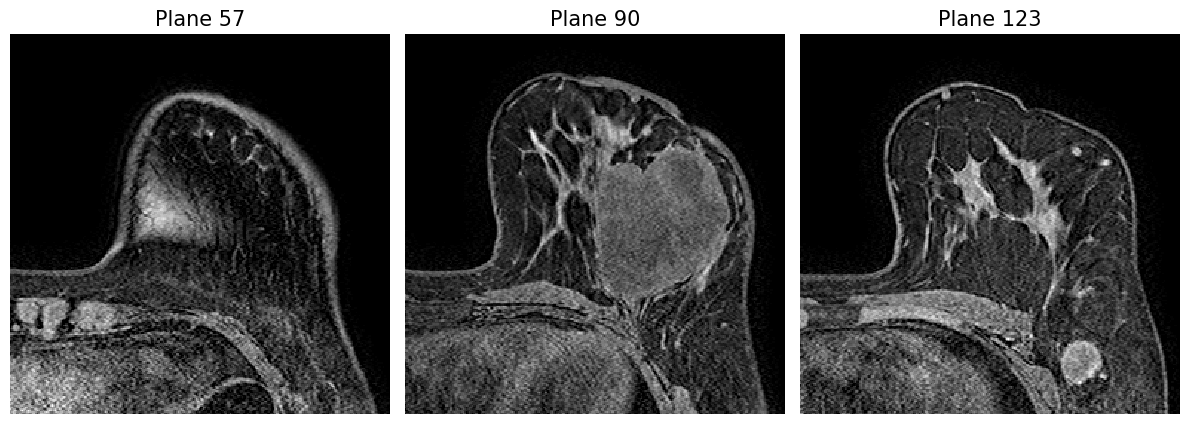

====  Scan:  1


<Figure size 640x480 with 0 Axes>

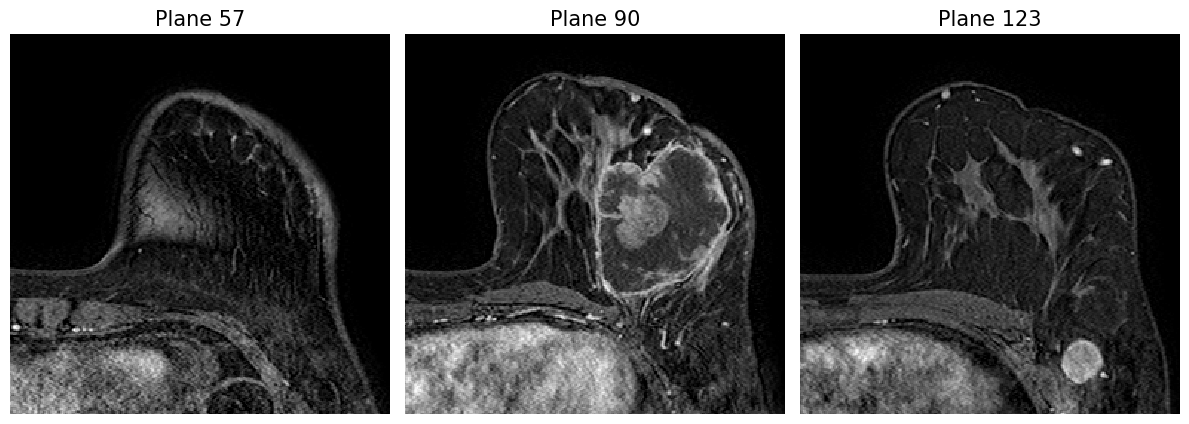

====  Scan:  2


<Figure size 640x480 with 0 Axes>

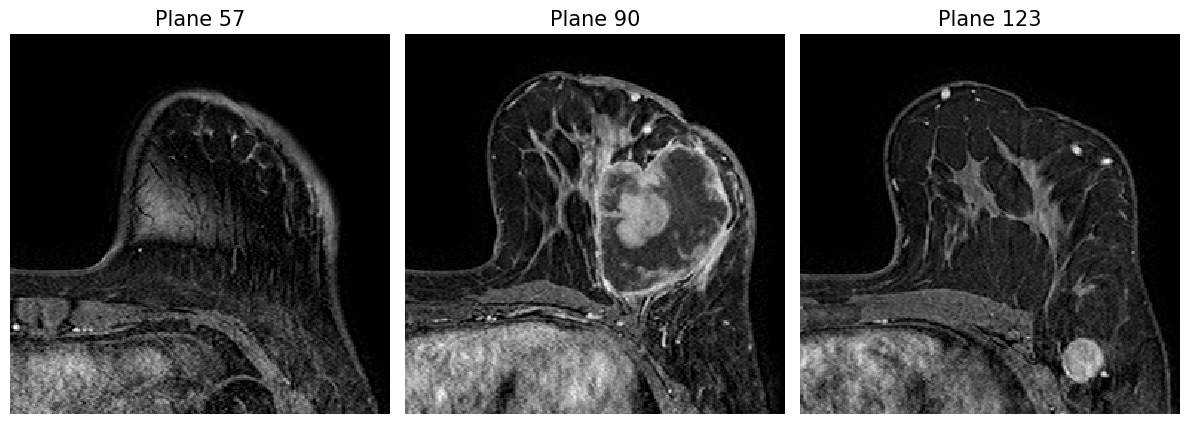

In [52]:
for k in range(len(d)):
    idx=[int(r['mask_start'])-1, int(r['mask_end']+r['mask_start'])//2, int(r['mask_end'])]
    print('====  Scan: ', k)
    ds.show_n_images([d[k][i] for i in idx], titles=['Plane '+str(i) for i in idx])


## print info of scans

In [53]:
for k in range(len(d)):

    print('====  Scan: ', k)
    ds.print_info([d[k][i] for i in idx])


====  Scan:  0
(256, 256) 0.0 1751.0 253.18589782714844 321.73892475517783 n!=0: 37449 443.07701140217364 float64
(256, 256) 0.0 1939.0 349.36671447753906 337.8391369222718 n!=0: 45422 504.07505173704374 float64
(256, 256) 0.0 1782.0 311.6083526611328 329.29989750122905 n!=0: 44295 461.03544418105884 float64
====  Scan:  1
(256, 256) 0.0 2939.0 341.2039337158203 446.61229817661444 n!=0: 38272 584.2689433528428 float64
(256, 256) 0.0 3158.0 615.9249572753906 668.239484276139 n!=0: 46145 874.7482500812656 float64
(256, 256) 0.0 3721.0 489.30067443847656 569.3900175619119 n!=0: 44731 716.8811115333884 float64
====  Scan:  2
(256, 256) 0.0 3127.0 381.7019805908203 482.4186381847214 n!=0: 38411 651.2514904584624 float64
(256, 256) 0.0 3221.0 651.9209747314453 694.9097074157875 n!=0: 46074 927.2972392238572 float64
(256, 256) 0.0 3502.0 507.1714324951172 558.8269145001972 n!=0: 45003 738.5726951536565 float64


====  Scan:  0


<Figure size 640x480 with 0 Axes>

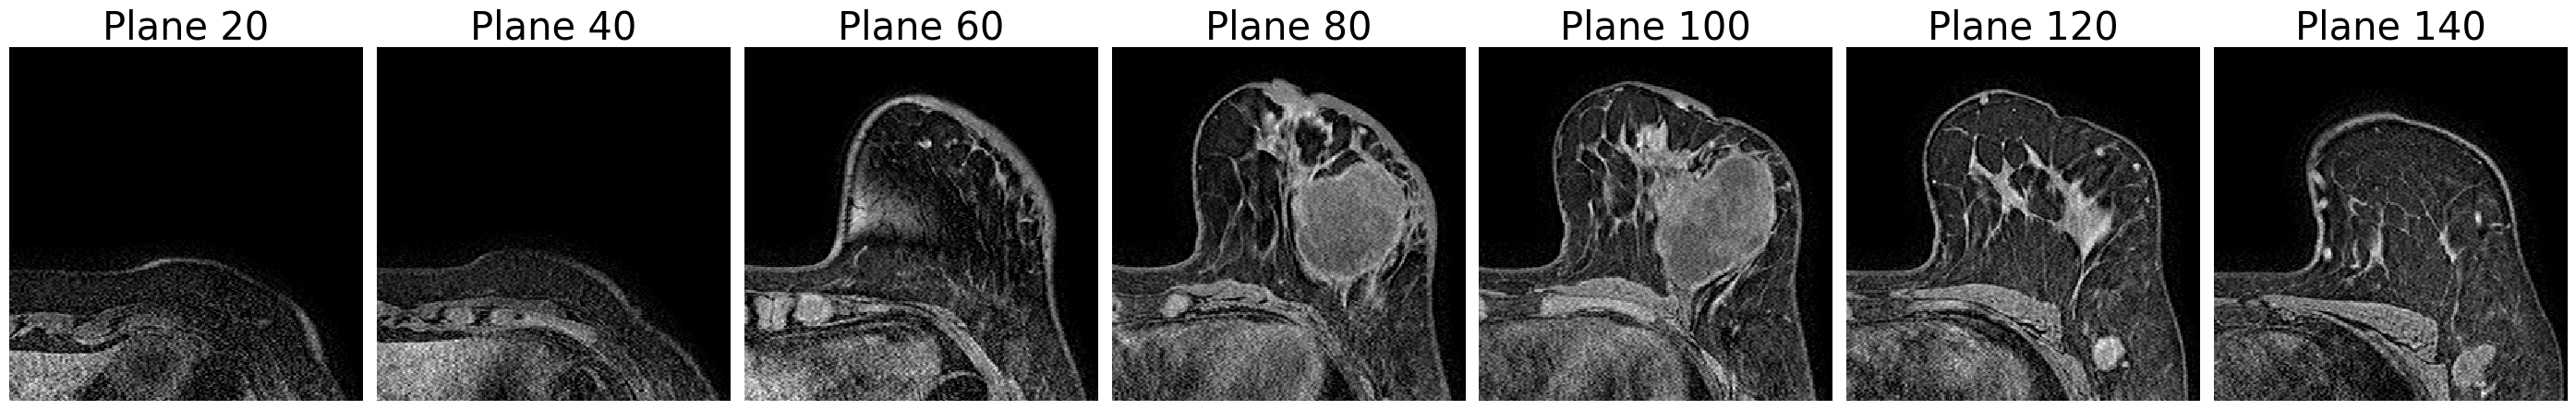

====  Scan:  1


<Figure size 640x480 with 0 Axes>

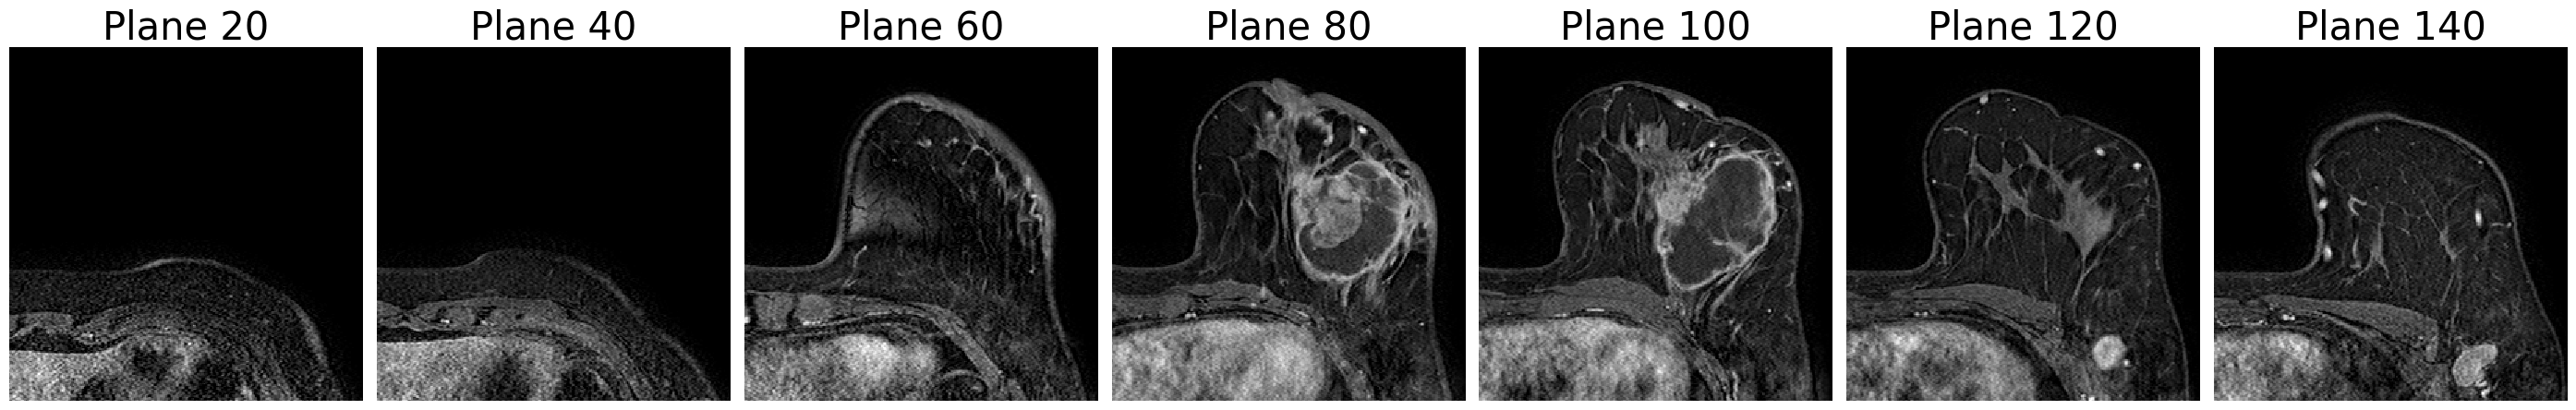

====  Scan:  2


<Figure size 640x480 with 0 Axes>

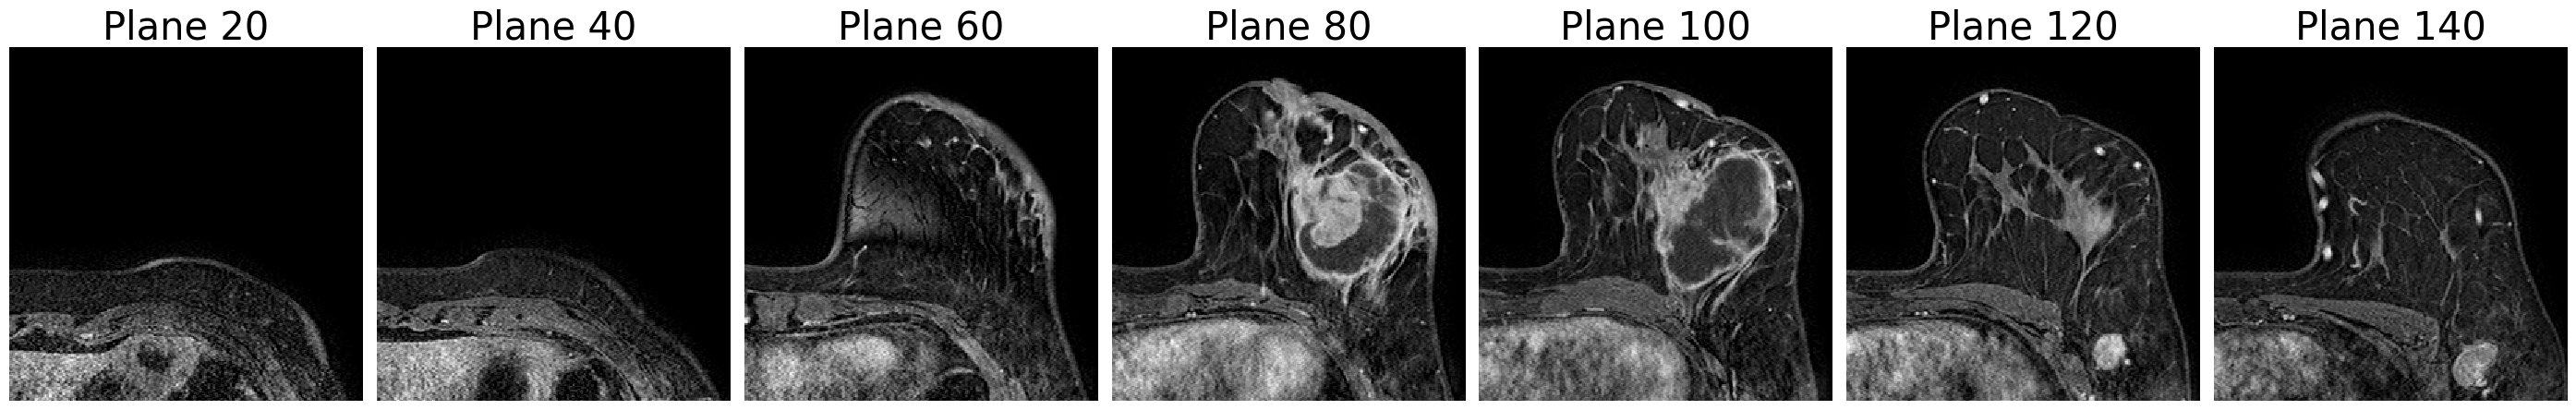

In [54]:
for k in range(len(d)):
    idx=list(range(20,int(r['n_z']),20))
    print('====  Scan: ', k)
    ds.show_n_images([d[k][i] for i in idx], titles=['Plane '+str(i) for i in idx], fontsize=30)


ISPY2-550421 spy2 num axquisitions: 3
mask: (160, 256, 256) 81


<Figure size 640x480 with 0 Axes>

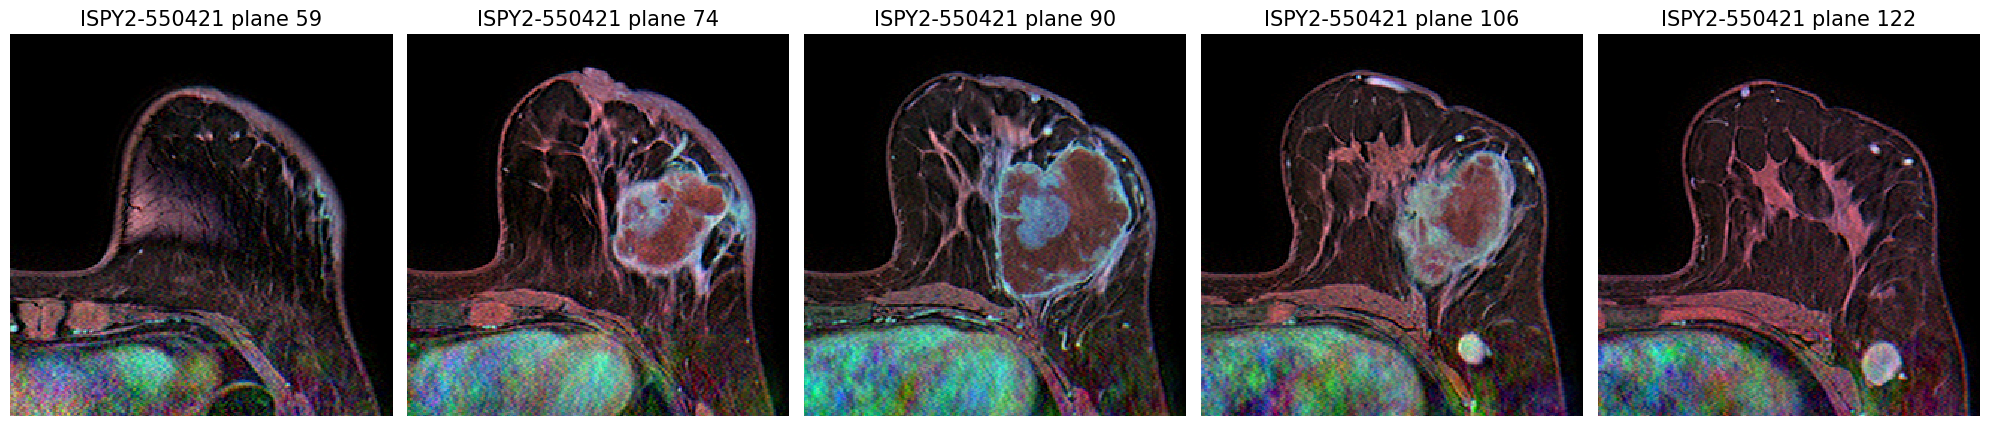

<Figure size 640x480 with 0 Axes>

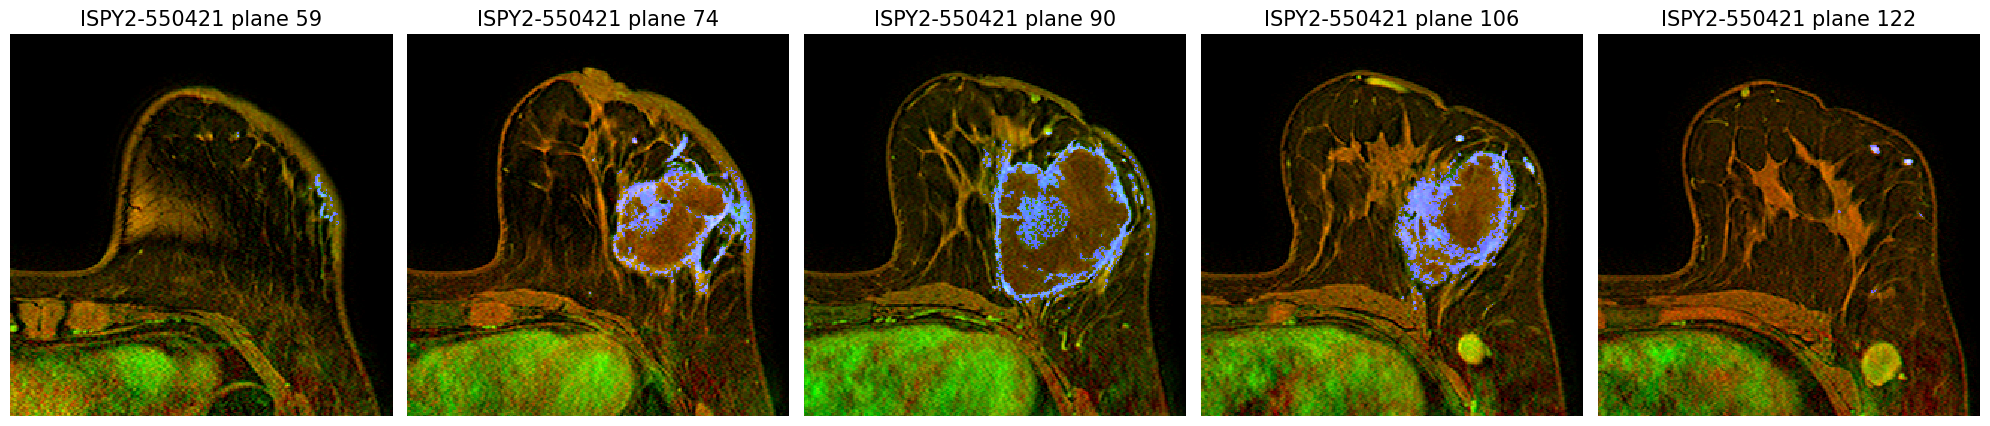

<Figure size 640x480 with 0 Axes>

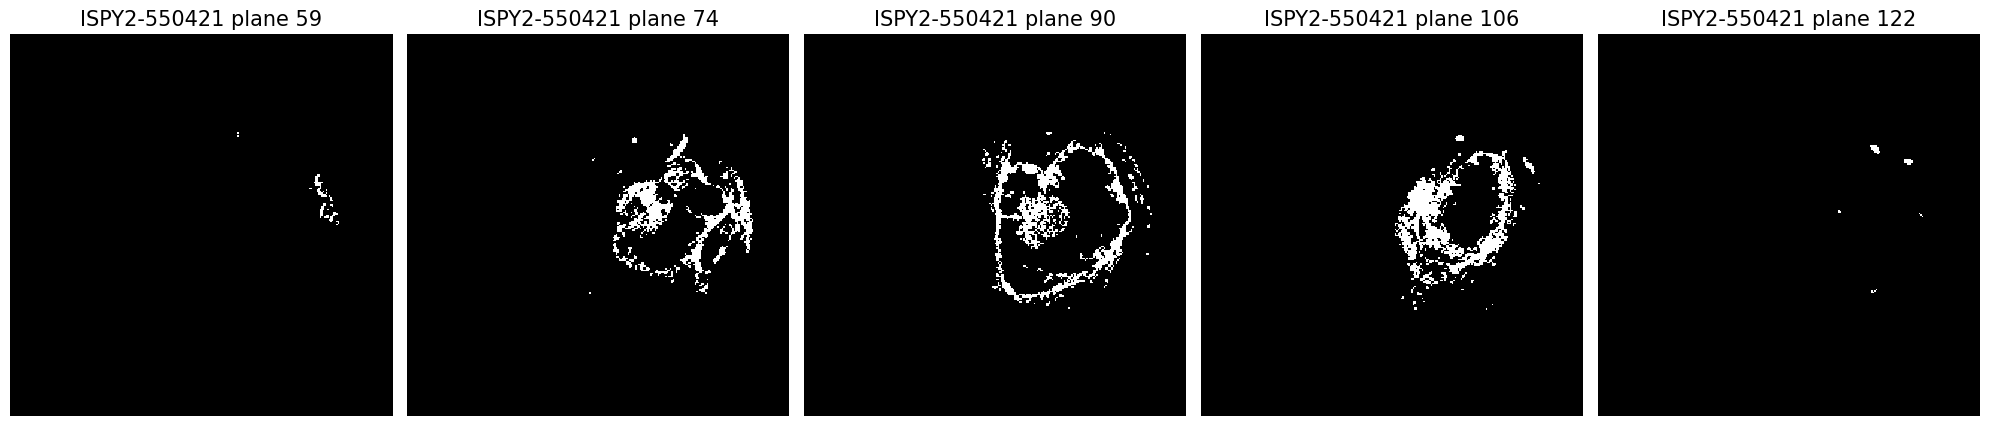

In [56]:
ds.show_pid(subject_id, ser)

In [57]:
pid='ACRIN-6698-102212'
r=df[df.pid==pid]


In [58]:
ser = [int(r['pre']),int(r['post_early']),int(r['post_late'])] #[0,2,6]
print(ser)

d = ds.get_ser_acquisitions(pid, ser=ser)
print(ser,d[0].shape)

m = ds.get_nifti_mask(pid)
m.shape,m.max()

[0, 2, 6]
[0, 2, 6] (80, 256, 256)


((80, 256, 256), np.float64(1.0))

====  Scan:  0


<Figure size 640x480 with 0 Axes>

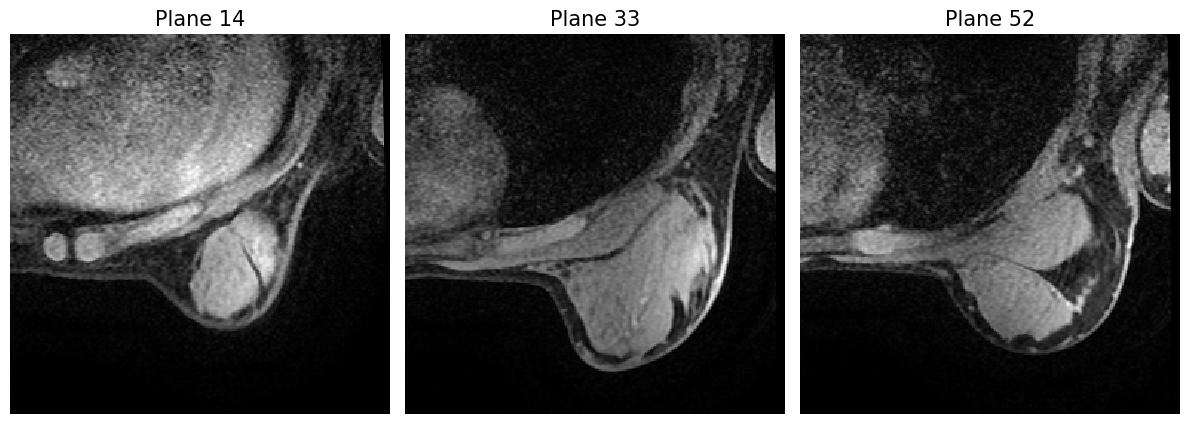

====  Scan:  1


<Figure size 640x480 with 0 Axes>

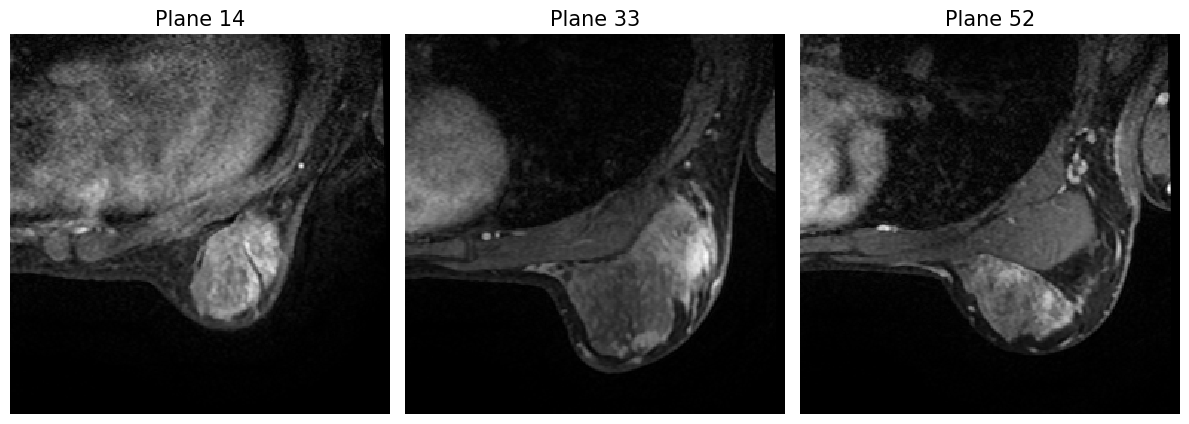

====  Scan:  2


<Figure size 640x480 with 0 Axes>

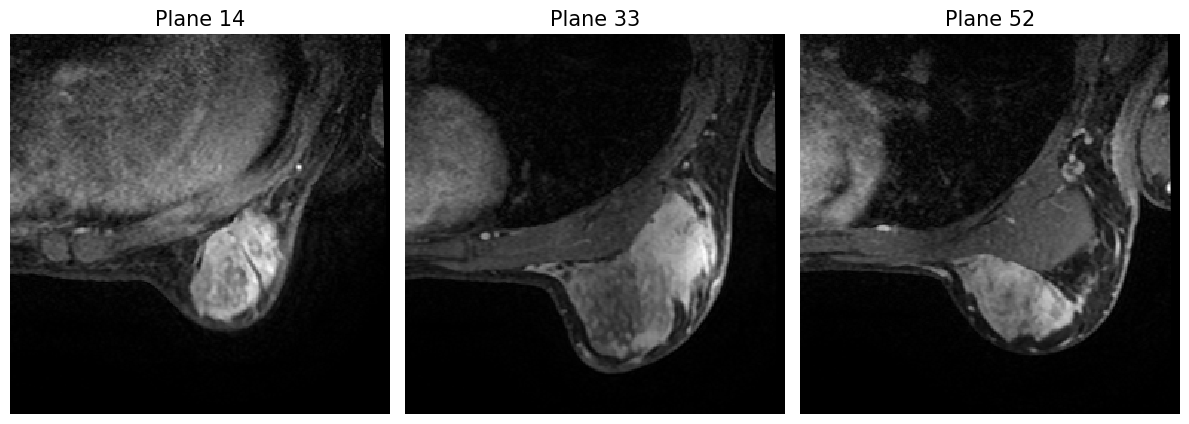

In [59]:
for k in range(len(d)):
    idx=[int(r['mask_start'])-1, int(r['mask_end']+r['mask_start'])//2, int(r['mask_end'])]
    print('====  Scan: ', k)
    ds.show_n_images([d[k][i] for i in idx], titles=['Plane '+str(i) for i in idx])


ACRIN-6698-102212 spy2 num axquisitions: 3
mask: (80, 256, 256) -73


<Figure size 640x480 with 0 Axes>

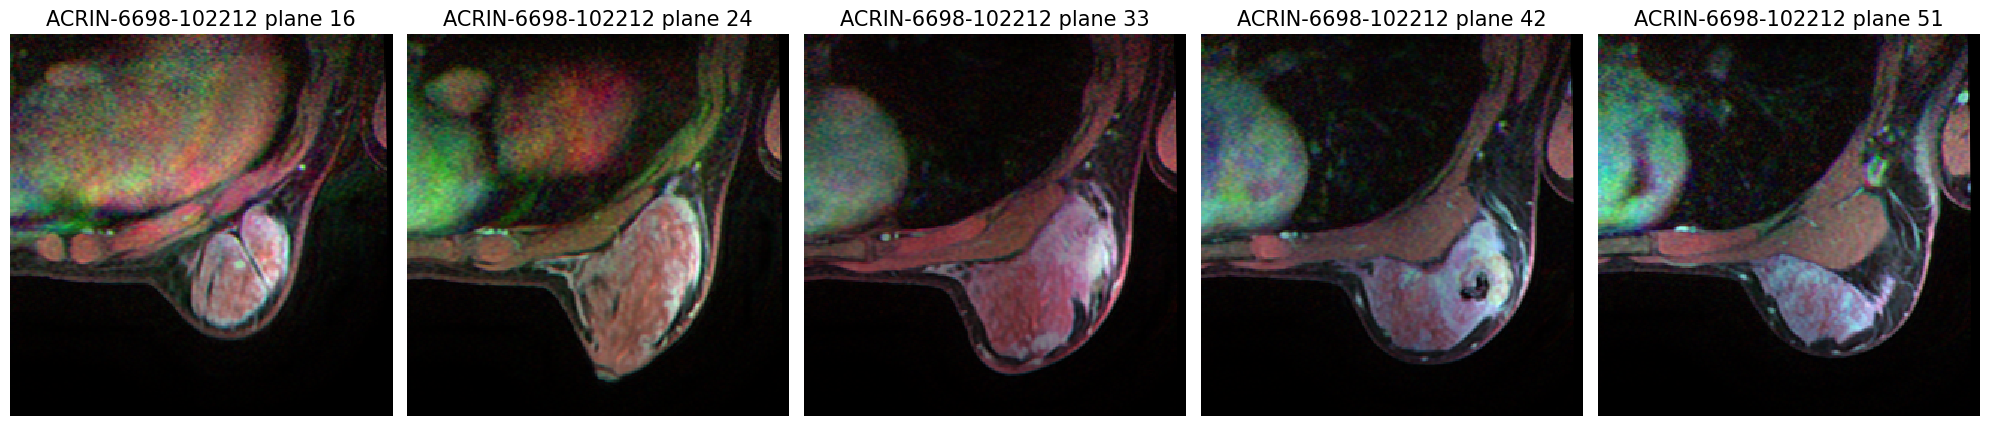

<Figure size 640x480 with 0 Axes>

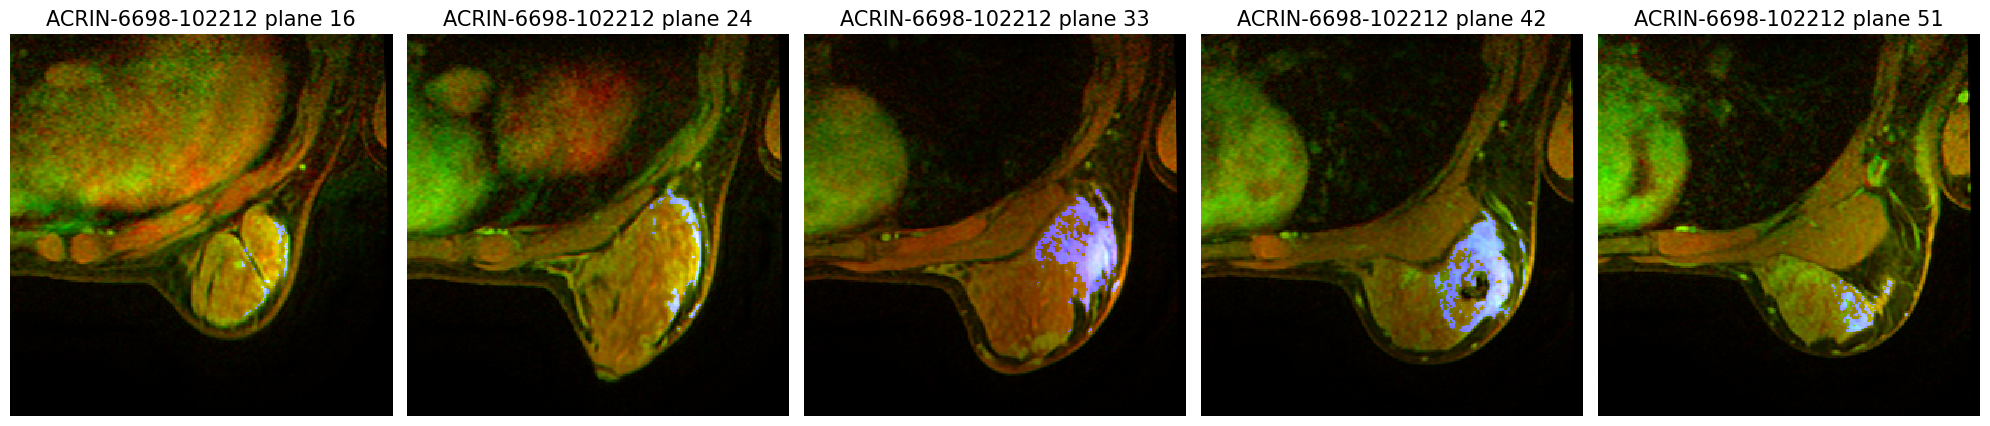

<Figure size 640x480 with 0 Axes>

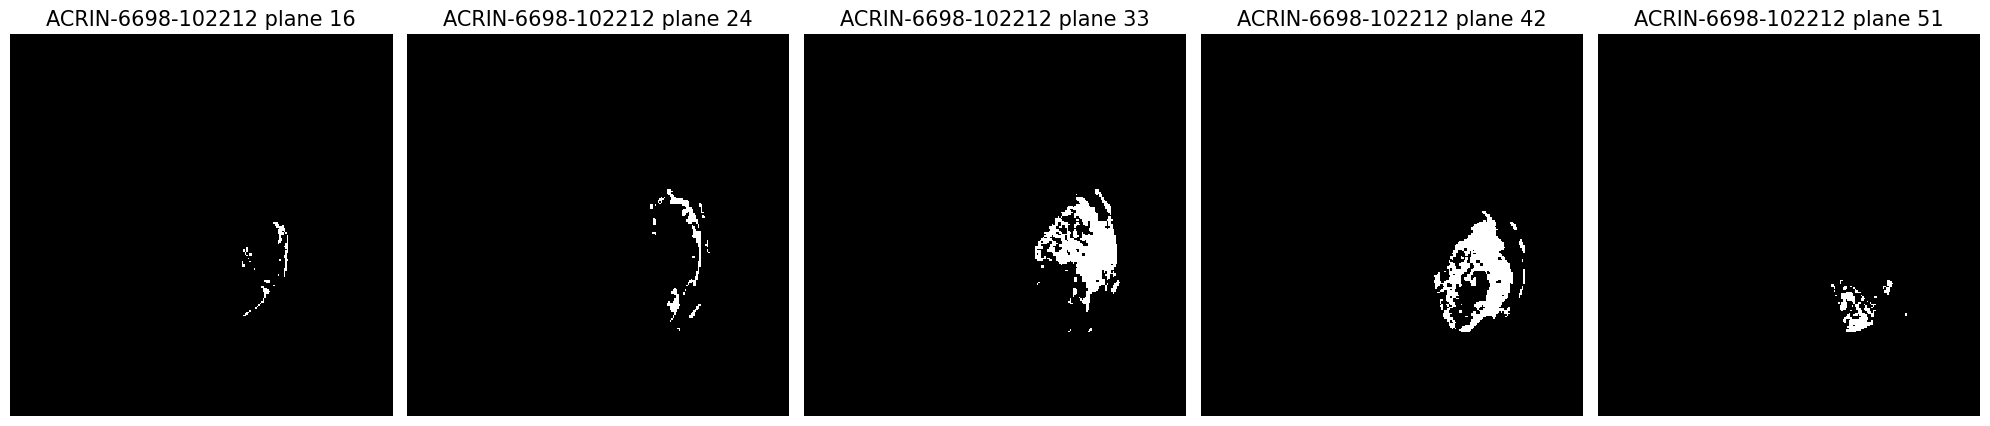

In [47]:
ds.show_pid(pid, ser)

# Predict pCR with ML

In [ ]:
for i,row in df.iterrows():
        p=row['pid']
        mc1 = -row['mask_start']+row['mask_end']
        mc2=-row['sraw']+row['eraw']
        mc3=-row['scol']+row['ecol']

        df.at[i,'bbox_vol']=row['slice_thick']*row['xy_spacing']*row['xy_spacing']*(mc1*mc2*mc3)/1000
        df.at[i,'bbox_count']=(mc1*mc2*mc3)
        df.at[i,'voxel_vol']=row['slice_thick']*row['xy_spacing']*row['xy_spacing']/1000
        m = ds.get_nifti_mask(p)
        m=m/m.max()
        m_counts=m.sum()
        df.at[i,'mask_count']=m_counts
        df.at[i, 'tum_vol']=row['slice_thick']*row['xy_spacing']*row['xy_spacing']*m_counts/1000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                982 non-null    object 
 1   Arm                982 non-null    object 
 2   HR                 982 non-null    int64  
 3   HER2               982 non-null    int64  
 4   MP                 982 non-null    int64  
 5   pCR                982 non-null    int64  
 6   age                979 non-null    float64
 7   Race               979 non-null    object 
 8   menopausal_status  895 non-null    object 
 9   e_hispanic_latino  981 non-null    float64
 10  Arm_split          982 non-null    object 
 11  ABT 888            982 non-null    int64  
 12  AMG 386            982 non-null    int64  
 13  Carboplatin        982 non-null    int64  
 14  Ganetespib         982 non-null    int64  
 15  Ganitumab          982 non-null    int64  
 16  MK-2206            982 non

# EDA

In [ ]:
df.columns

Index(['pid', 'Arm', 'HR', 'HER2', 'MP', 'pCR', 'age', 'Race',
       'menopausal_status', 'e_hispanic_latino', 'Arm_split', 'ABT 888',
       'AMG 386', 'Carboplatin', 'Ganetespib', 'Ganitumab', 'MK-2206',
       'Neratinib', 'Paclitaxel', 'Pembrolizumab', 'Pertuzumab', 'T-DM1',
       'Trastuzumab', 'race_white', 'race_black', 'perimenops', 'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg', 'dataset', 'HR_HER2_STATUS',
       'n_xy', 'n_z', 'n_times', 'pre', 'post_early', 'post_late',
       'slice_thick', 'xy_spacing', 'mask_start', 'mask_end', 'mask_count',
       'is_mask', 'sraw', 'eraw', 'scol', 'ecol', 'test', 'bbox_vol',
       'bbox_count', 'voxel_vol', 'tum_vol'],
      dtype='object')

In [ ]:
cols=[ 'HR', 'HER2', 'MP', 'pCR', 'age',
        'e_hispanic_latino',  'ABT 888',
       'AMG 386', 'Carboplatin', 'Ganetespib', 'Ganitumab', 'MK-2206',
       'Neratinib', 'Paclitaxel', 'Pembrolizumab', 'Pertuzumab', 'T-DM1',
       'Trastuzumab', 'race_white', 'race_black', 'perimenops', 'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg']

In [ ]:
for c in cols:
    print(df[c].value_counts(dropna=False))

HR
1    536
0    446
Name: count, dtype: int64
HER2
0    740
1    242
Name: count, dtype: int64
MP
0    502
1    480
Name: count, dtype: int64
pCR
0    666
1    316
Name: count, dtype: int64
age
50.0    43
46.0    41
57.0    39
56.0    37
44.0    36
45.0    35
54.0    35
52.0    32
49.0    32
47.0    31
53.0    29
39.0    28
48.0    28
41.0    28
58.0    27
42.0    27
51.0    26
59.0    25
55.0    25
37.0    24
43.0    24
36.0    22
63.0    21
32.0    19
38.0    18
64.0    18
40.0    18
35.0    18
60.0    17
33.0    17
34.0    15
61.0    15
65.0    15
68.0    13
31.0    13
62.0     9
67.0     9
30.0     9
70.0     9
66.0     9
29.0     8
69.0     8
28.0     6
25.0     4
71.0     4
27.0     4
NaN      3
26.0     2
72.0     2
73.0     2
23.0     1
77.0     1
24.0     1
Name: count, dtype: int64
e_hispanic_latino
0.0    860
1.0    121
NaN      1
Name: count, dtype: int64
ABT 888
0    912
1     70
Name: count, dtype: int64
AMG 386
0    848
1    134
Name: count, dtype: int64
Carboplatin
0  

In [ ]:
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HR                 982 non-null    int64  
 1   HER2               982 non-null    int64  
 2   MP                 982 non-null    int64  
 3   pCR                982 non-null    int64  
 4   age                979 non-null    float64
 5   e_hispanic_latino  981 non-null    float64
 6   ABT 888            982 non-null    int64  
 7   AMG 386            982 non-null    int64  
 8   Carboplatin        982 non-null    int64  
 9   Ganetespib         982 non-null    int64  
 10  Ganitumab          982 non-null    int64  
 11  MK-2206            982 non-null    int64  
 12  Neratinib          982 non-null    int64  
 13  Paclitaxel         982 non-null    int64  
 14  Pembrolizumab      982 non-null    int64  
 15  Pertuzumab         982 non-null    int64  
 16  T-DM1              982 non

In [ ]:
df['age']=df['age'].fillna(df.age.mean())

In [ ]:
# Only update rows where menopause is NaN
mask = df['menopause'].isna()
df.loc[mask, 'menopause'] = (df.loc[mask, 'age'] > 50).astype(int)

In [ ]:
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HR                 982 non-null    int64  
 1   HER2               982 non-null    int64  
 2   MP                 982 non-null    int64  
 3   pCR                982 non-null    int64  
 4   age                982 non-null    float64
 5   e_hispanic_latino  981 non-null    float64
 6   ABT 888            982 non-null    int64  
 7   AMG 386            982 non-null    int64  
 8   Carboplatin        982 non-null    int64  
 9   Ganetespib         982 non-null    int64  
 10  Ganitumab          982 non-null    int64  
 11  MK-2206            982 non-null    int64  
 12  Neratinib          982 non-null    int64  
 13  Paclitaxel         982 non-null    int64  
 14  Pembrolizumab      982 non-null    int64  
 15  Pertuzumab         982 non-null    int64  
 16  T-DM1              982 non

In [ ]:
#df[cols].to_csv('BreastDCEDL_ispy2_eda_metadata.csv', index = False)

In [ ]:
df_pred = pd.read_csv('../BreastDCEDL_vit_pcr_predictions.csv')
df=df.merge(df_pred[['pid','DL_pred_pcr_mean','DL_pred_pcr_min']], on='pid', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                982 non-null    object 
 1   Arm                982 non-null    object 
 2   HR                 982 non-null    int64  
 3   HER2               982 non-null    int64  
 4   MP                 982 non-null    int64  
 5   pCR                982 non-null    int64  
 6   age                982 non-null    float64
 7   Race               979 non-null    object 
 8   menopausal_status  895 non-null    object 
 9   e_hispanic_latino  981 non-null    float64
 10  Arm_split          982 non-null    object 
 11  ABT 888            982 non-null    int64  
 12  AMG 386            982 non-null    int64  
 13  Carboplatin        982 non-null    int64  
 14  Ganetespib         982 non-null    int64  
 15  Ganitumab          982 non-null    int64  
 16  MK-2206            982 non

In [ ]:
df.columns

Index(['pid', 'Arm', 'HR', 'HER2', 'MP', 'pCR', 'age', 'Race',
       'menopausal_status', 'e_hispanic_latino', 'Arm_split', 'ABT 888',
       'AMG 386', 'Carboplatin', 'Ganetespib', 'Ganitumab', 'MK-2206',
       'Neratinib', 'Paclitaxel', 'Pembrolizumab', 'Pertuzumab', 'T-DM1',
       'Trastuzumab', 'race_white', 'race_black', 'perimenops', 'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg', 'dataset', 'HR_HER2_STATUS',
       'n_xy', 'n_z', 'n_times', 'pre', 'post_early', 'post_late',
       'slice_thick', 'xy_spacing', 'mask_start', 'mask_end', 'mask_count',
       'is_mask', 'sraw', 'eraw', 'scol', 'ecol', 'test', 'bbox_vol',
       'bbox_count', 'voxel_vol', 'tum_vol', 'DL_pred_pcr_mean',
       'DL_pred_pcr_min'],
      dtype='object')

## Predict on Metadata only without Deep Learning

In [ ]:
    df_test=df[df.test==1]
    df_valid=df[df.test==2]
    df_train=df[df.test==0]
    df_val_train=df[df.test!=1]



 Test  Accuracy:  0.737  AUC:  0.745   Specificity: 0.91   Sensitivity: 0.375 NPV: 0.753 Precision: 0.667
   No  Yes
0  61    6
1  20   12
Random Forest Results:
AUC: 0.7449
Accuracy: 0.7374
F1-score: 0.4800

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        67
           1       0.67      0.38      0.48        32

    accuracy                           0.74        99
   macro avg       0.71      0.64      0.65        99
weighted avg       0.73      0.74      0.71        99



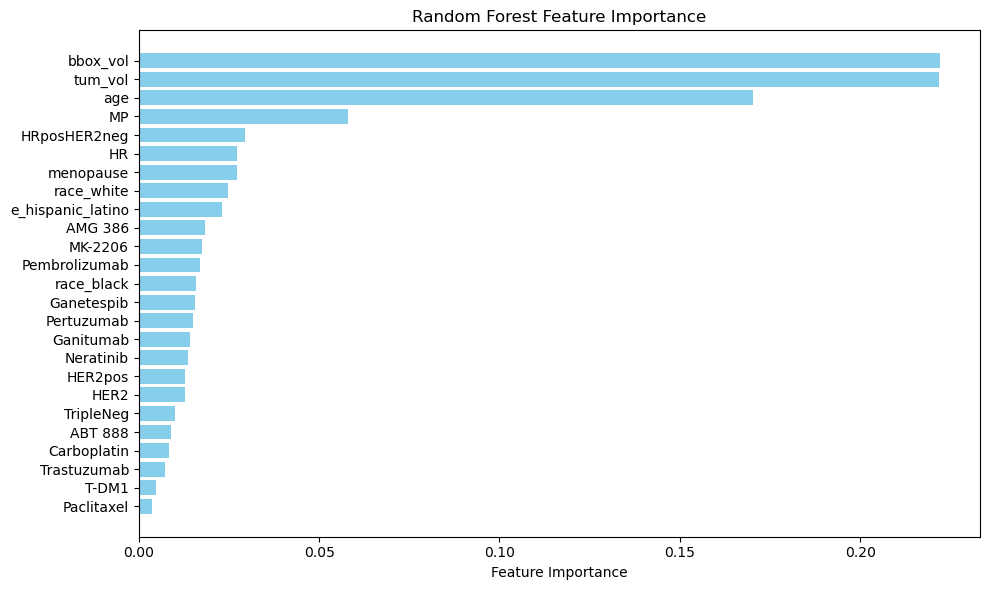

In [ ]:
    pcols=[ 'HR', 'HER2', 'MP',  'age',
        'e_hispanic_latino',  'ABT 888',
       'AMG 386', 'Carboplatin', 'Ganetespib', 'Ganitumab', 'MK-2206',
       'Neratinib', 'Paclitaxel', 'Pembrolizumab', 'Pertuzumab', 'T-DM1',
       'Trastuzumab', 'race_white', 'race_black',  'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg',
       # 'mask_count',
         'bbox_vol',
     #  'bbox_count', 'voxel_vol',
       'tum_vol',
          # 'DL_pred_pcr_mean',
      # 'DL_pred_pcr_min'
          ]



    X_train = df_val_train[pcols].values
    y_train = df_val_train['pCR'].values

    X_test = df_test[pcols].values
    y_test=df_test.pCR.values

    # Standardize features
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        class_weight='balanced'
    )

    # Train Random Forest
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions with Random Forest
    rf_pred = rf_model.predict(X_test_scaled)
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for Random Forest
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)

    # y, y_pred, tlt = 'Train',classes=['Negative', 'pCR pos'],
    #            c_rep = 0, Thresh=0.5, plot_roc_c=0, plot_cm=0):
    ds.report_full(y=y_test, y_pred=rf_pred_proba, tlt='Test',
                plot_roc_c=0)
    # Print Random Forest results
    print("Random Forest Results:")
    print(f"AUC: {rf_auc:.4f}")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(f"F1-score: {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))

    if 1:
        # Create a DataFrame for feature importance
        importance_df = pd.DataFrame({
            'feature': pcols,
            'importance': rf_model.feature_importances_
        })

        # Sort features by importance in descending order.
        importance_df.sort_values('importance', ascending=False, inplace=True)

        # Create a horizontal bar plot
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
        plt.xlabel("Feature Importance")
        plt.title("Random Forest Feature Importance")
        plt.gca().invert_yaxis()  # Highest importance at the top
        plt.tight_layout()
        plt.show()


In [ ]:
    pcols=[ 'HR', 'HER2', 'MP',  'age',
        'e_hispanic_latino',
           'ABT 888',
       'AMG 386', 'Carboplatin', 'Ganetespib', 'Ganitumab', 'MK-2206',
       'Neratinib', 'Paclitaxel', 'Pembrolizumab', 'Pertuzumab', 'T-DM1',
       'Trastuzumab', 'race_white',
           #'race_black', # 'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg',
        #'mask_count',
         'bbox_vol',
      # 'bbox_count',# 'voxel_vol',
       'tum_vol',
           'DL_pred_pcr_mean',
       'DL_pred_pcr_min'
          ]


    X_train = df_val_train[pcols].values
    y_train = df_val_train['pCR'].values

    X_test = df_test[pcols].values
    y_test=df_test.pCR.values

In [ ]:
    # Standardize features
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        #class_weight='balanced'
    )

    # Train Random Forest
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions with Random Forest
    rf_pred = rf_model.predict(X_test_scaled)
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for Random Forest
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)

    # y, y_pred, tlt = 'Train',classes=['Negative', 'pCR pos'],
    #            c_rep = 0, Thresh=0.5, plot_roc_c=0, plot_cm=0):
    ds.report_full(y=y_test, y_pred=rf_pred_proba, tlt='Test',
                plot_roc_c=0)
    # Print Random Forest results
    print("Random Forest Results:")
    print(f"AUC: {rf_auc:.4f}")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(f"F1-score: {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))


 Test  Accuracy:  0.768  AUC:  0.849   Specificity: 0.94   Sensitivity: 0.406 NPV: 0.768 Precision: 0.765
   No  Yes
0  63    4
1  19   13
Random Forest Results:
AUC: 0.8486
Accuracy: 0.7677
F1-score: 0.5306

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        67
           1       0.76      0.41      0.53        32

    accuracy                           0.77        99
   macro avg       0.77      0.67      0.69        99
weighted avg       0.77      0.77      0.74        99



In [ ]:
    pcols=[ 'HR', 'HER2', 'MP',  'age',
        'e_hispanic_latino',
           'ABT 888',
       'AMG 386', 'Carboplatin', 'Ganetespib', 'Ganitumab', 'MK-2206',
       'Neratinib', 'Paclitaxel', 'Pembrolizumab', 'Pertuzumab', 'T-DM1',
       'Trastuzumab', 'race_white',
           #'race_black', # 'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg',
        #'mask_count',
         'bbox_vol',
      # 'bbox_count',# 'voxel_vol',
       'tum_vol',
           'DL_pred_pcr_mean',
       'DL_pred_pcr_min'
          ]


    X_train = df_val_train[pcols].values
    y_train = df_val_train['pCR'].values

    X_test = df_test[pcols][df_test.HER2pos==1].values
    y_test=df_test[df_test.HER2pos==1].pCR.values
    X_test.shape,y_test

((19, 25),
 array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       dtype=int64))

In [ ]:
    # Standardize features
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        #class_weight='balanced'
    )

    # Train Random Forest
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions with Random Forest
    rf_pred = rf_model.predict(X_test_scaled)
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for Random Forest
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)

    # y, y_pred, tlt = 'Train',classes=['Negative', 'pCR pos'],
    #            c_rep = 0, Thresh=0.5, plot_roc_c=0, plot_cm=0):
    ds.report_full(y=y_test, y_pred=rf_pred_proba, tlt='Test',
                plot_roc_c=0)
    # Print Random Forest results
    print("Random Forest Results:")
    print(f"AUC: {rf_auc:.4f}")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(f"F1-score: {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))


 Test  Accuracy:  0.737  AUC:  0.818   Specificity: 0.909   Sensitivity: 0.5 NPV: 0.714 Precision: 0.8
   No  Yes
0  10    1
1   4    4
Random Forest Results:
AUC: 0.8182
Accuracy: 0.7368
F1-score: 0.6154

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.80      0.50      0.62         8

    accuracy                           0.74        19
   macro avg       0.76      0.70      0.71        19
weighted avg       0.75      0.74      0.72        19



In [ ]:
    X_train = df_val_train[pcols].values
    y_train = df_val_train['pCR'].values

    X_test = df_test[pcols][df_test.HRposHER2neg==1].values
    y_test=df_test[df_test.HRposHER2neg==1].pCR.values
    X_test.shape,y_test

    # Standardize features
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        #class_weight='balanced'
    )

    # Train Random Forest
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions with Random Forest
    rf_pred = rf_model.predict(X_test_scaled)
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for Random Forest
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)

    # y, y_pred, tlt = 'Train',classes=['Negative', 'pCR pos'],
    #            c_rep = 0, Thresh=0.5, plot_roc_c=0, plot_cm=0):
    ds.report_full(y=y_test, y_pred=rf_pred_proba, tlt='Test',
                plot_roc_c=0)
    # Print Random Forest results
    print("Random Forest Results:")
    print(f"AUC: {rf_auc:.4f}")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(f"F1-score: {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))


 Test  Accuracy:  0.925  AUC:  0.94   Specificity: 1.0   Sensitivity: 0.4 NPV: 0.921 Precision: 1.0
   No  Yes
0  35    0
1   3    2
Random Forest Results:
AUC: 0.9400
Accuracy: 0.9250
F1-score: 0.5714

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.40      0.57         5

    accuracy                           0.93        40
   macro avg       0.96      0.70      0.77        40
weighted avg       0.93      0.93      0.91        40



In [ ]:
    X_train = df_val_train[pcols].values
    y_train = df_val_train['pCR'].values

    X_test = df_test[pcols][df_test.TripleNeg==1].values
    y_test=df_test[df_test.TripleNeg==1].pCR.values
    X_test.shape,y_test

    # Standardize features
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        #class_weight='balanced'
    )

    # Train Random Forest
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions with Random Forest
    rf_pred = rf_model.predict(X_test_scaled)
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for Random Forest
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)

    # y, y_pred, tlt = 'Train',classes=['Negative', 'pCR pos'],
    #            c_rep = 0, Thresh=0.5, plot_roc_c=0, plot_cm=0):
    ds.report_full(y=y_test, y_pred=rf_pred_proba, tlt='Test',
                plot_roc_c=0)
    # Print Random Forest results
    print("Random Forest Results:")
    print(f"AUC: {rf_auc:.4f}")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(f"F1-score: {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))


 Test  Accuracy:  0.625  AUC:  0.726   Specificity: 0.857   Sensitivity: 0.368 NPV: 0.6 Precision: 0.7
   No  Yes
0  18    3
1  12    7
Random Forest Results:
AUC: 0.7256
Accuracy: 0.6250
F1-score: 0.4828

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71        21
           1       0.70      0.37      0.48        19

    accuracy                           0.62        40
   macro avg       0.65      0.61      0.59        40
weighted avg       0.65      0.62      0.60        40



## Code to create article figures

In [ ]:
# Create mapping from technical names to publication-ready names
feature_name_mapping = {
    # Clinical/Biomarker Features
    'HR': 'Hormone Receptor Status',
    'HER2': 'HER2 Status',
    'MP':  'MammaPrint Genomic Score',
    'age': 'Age',
    #'menopause': 'Menopausal Status',

    # Molecular Subtypes
    'HER2pos': 'HER2-Positive Subtype',
    'HRposHER2neg': 'HR+/HER2- Subtype',
    'TripleNeg': 'Triple-Negative Subtype',

    # Demographics
    'e_hispanic_latino': 'Hispanic/Latino Ethnicity',
    'race_white': 'White Race',
    #'race_black': 'Black Race',

    # Treatment Agents
    'ABT 888': 'ABT-888 (Veliparib)',
    'AMG 386': 'AMG-386 (Trebananib)',
    'Carboplatin': 'Carboplatin',
    'Ganetespib': 'Ganetespib',
    'Ganitumab': 'Ganitumab',
    'MK-2206': 'MK-2206 (AKT Inhibitor)',
    'Neratinib': 'Neratinib',
    'Paclitaxel': 'Paclitaxel',
    'Pembrolizumab': 'Pembrolizumab',
    'Pertuzumab': 'Pertuzumab',
    'T-DM1': 'T-DM1 (Trastuzumab Emtansine)',
    'Trastuzumab': 'Trastuzumab',

    # Imaging Features
    'bbox_vol': 'Bounding Box Volume',
    'tum_vol': 'Tumor Volume',
    'DL_pred_pcr_mean': 'Deep Learning pCR Score (Mean)',
    'DL_pred_pcr_min': 'Deep Learning pCR Score (Min)'
}

# Apply mapping to create nice names
feature_names_nice = [feature_name_mapping.get(name, name) for name in pcols]

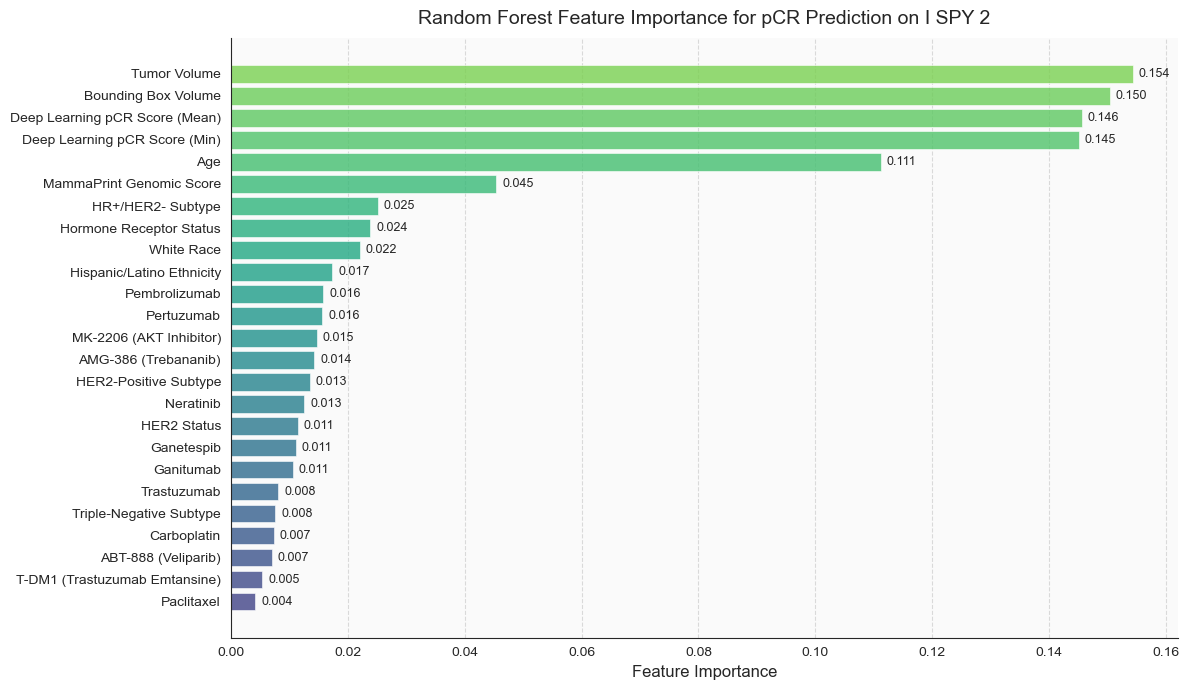

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get feature importances from your trained model
importances = rf_model.feature_importances_
feature_names_nice = [feature_name_mapping.get(name, name) for name in pcols]

# Create DataFrame for easier manipulation
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names_nice,
    'importance': importances,
    'original_name': pcols
}).sort_values('importance', ascending=True)

# Create the plot
plt.figure(figsize=(12,7))

# Use a nice color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_df)))

# Create horizontal bar plot
bars = plt.barh(range(len(importance_df)), importance_df['importance'],
                color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)

# Customize the plot
plt.yticks(range(len(importance_df)), importance_df['feature'], fontsize=10)
plt.xlabel('Feature Importance', fontsize=12)#, fontweight='bold')
plt.title('Random Forest Feature Importance for pCR Prediction on I SPY 2',
          fontsize=14, pad=10)

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, importance_df['importance'])):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center', fontsize=9)

# Style improvements
plt.grid(axis='x', alpha=0.7, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Add subtle background color
plt.gca().set_facecolor('#fafafa')

plt.show()


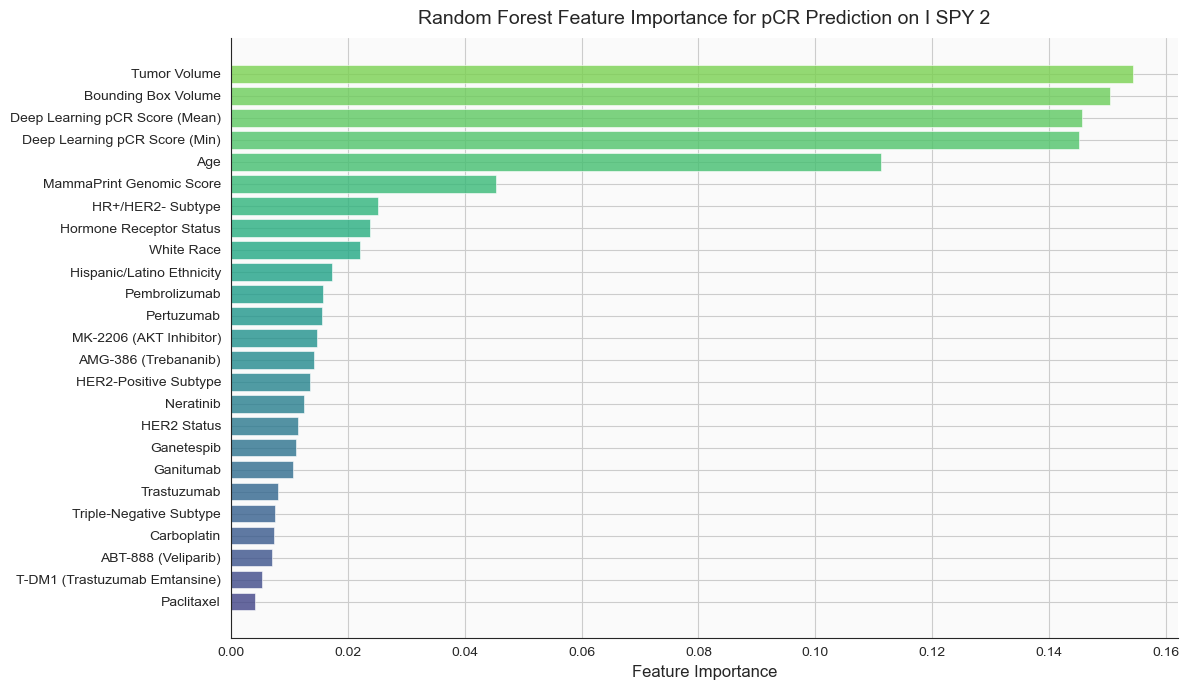

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("white")
# Get feature importances from your trained model
importances = rf_model.feature_importances_
feature_names_nice = [feature_name_mapping.get(name, name) for name in pcols]

# Create DataFrame for easier manipulation
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names_nice,
    'importance': importances,
    'original_name': pcols
}).sort_values('importance', ascending=True)

# Create the plot
plt.figure(figsize=(12,7))

# Use a nice color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_df)))

# Create horizontal bar plot
bars = plt.barh(range(len(importance_df)), importance_df['importance'],
                color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)

# Customize the plot
plt.yticks(range(len(importance_df)), importance_df['feature'], fontsize=10)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance for pCR Prediction on I SPY 2',
          fontsize=14, pad=10)


# Style improvements
plt.grid('off')
#plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Add subtle background color
plt.gca().set_facecolor('#fafafa')

plt.show()


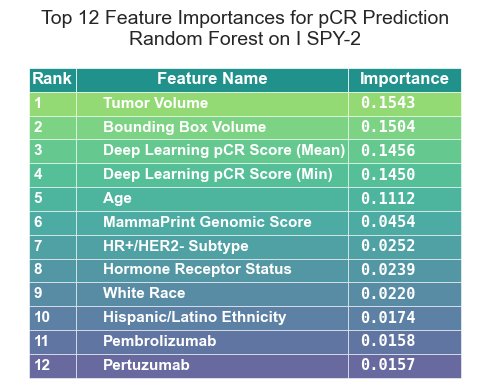

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Set seaborn style for consistent aesthetics
sns.set_style("white")

# Get feature importances from your trained model
importances = rf_model.feature_importances_
feature_names_nice = [feature_name_mapping.get(name, name) for name in pcols]

# Create DataFrame for easier manipulation
importance_df = pd.DataFrame({
    'feature': feature_names_nice,
    'importance': importances
}).sort_values('importance', ascending=False)  # Sort descending for top-first display

# Create figure for dense table
fig, ax = plt.subplots(figsize=(5, 4))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
for rank, (_, row) in enumerate(importance_df.head(12).iterrows(), 1):
    table_data.append([rank, row['feature'], f"{row['importance']:.4f}"])

# Create table with tighter spacing
table = ax.table(cellText=table_data,
                 colLabels=['Rank', 'Feature Name', 'Importance'],
                 cellLoc='left',
                 loc='center',
                 colWidths=[0.1, 0.58, 0.24])

# Style the table for density
table.auto_set_font_size(False)
table.set_fontsize(12)  # Slightly larger font for better readability
table.scale(1, 1.4)     # Much tighter row spacing

# Generate viridis colors matching your bar plot style - REVERSED
colors = plt.cm.viridis(np.linspace(0.8, 0.2, 12))  # Reversed: green to blue

# Color the header with viridis dark
header_color = plt.cm.viridis(0.5)  # Dark viridis color
for i in range(3):
    table[(0, i)].set_facecolor(header_color)
    table[(0, i)].set_text_props(weight='bold', color='white', size=12)

# Color rows with viridis gradient (highest importance = green, lowest = blue)
for i in range(1, 13):
    # Use reversed viridis colors - rank 1 (highest importance) gets green
    row_color = colors[i-1]  # Colors now go from green to blue

    for j in range(3):
        table[(i, j)].set_facecolor(row_color)
        table[(i, j)].set_alpha(0.8)  # Match your bar plot alpha

        # Text styling - stronger text
        if j == 0:  # Rank column
            table[(i, j)].set_text_props(weight='bold', color='white', size=11)
        elif j == 1:  # Feature name
            table[(i, j)].set_text_props(weight='bold', color='white', size=11)  # Made bold
        else:  # Importance column
            table[(i, j)].set_text_props(family='monospace', weight='bold', color='white', size=11)  # Made bold

# Add subtle border matching your bar plot edge style
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)  # Match your bar plot linewidth
    cell.set_edgecolor('white')  # Match your bar plot edgecolor

# Title closer to table
ax.set_title('Top 12 Feature Importances for pCR Prediction\nRandom Forest on I SPY-2',
             fontsize=14, pad=15)  # Reduced pad from default to 5

plt.tight_layout()
plt.show()

Overall: 99 cases, AUC = 0.85
HER2+: 19 cases, AUC = 0.818
HR+/HER2-: 40 cases, AUC = 0.940
TripleNegative: 40 cases, AUC = 0.726


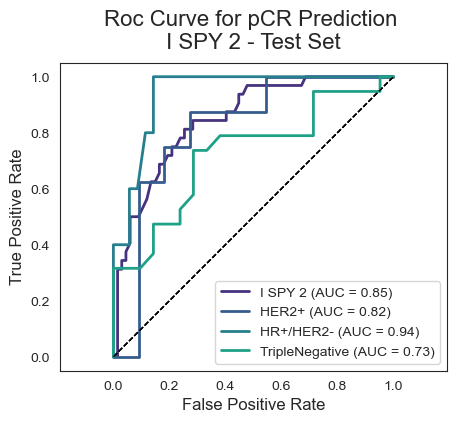

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Define the hormone receptor subtypes
subtypes = ['HER2pos', 'HRposHER2neg', 'TripleNeg']
#colors = ['red', 'blue', 'green']
subtype_names = ['HER2+', 'HR+/HER2-', 'TripleNegative']

plt.figure(figsize=(5,4))

# First plot the TOTAL ROC curve
fpr_total, tpr_total, _ = roc_curve(y_test, rf_pred_proba)
auc_total = auc(fpr_total, tpr_total)
plt.plot(fpr_total, tpr_total,  lw=2,
         label=f'I SPY 2 (AUC = {auc_total:.2f})')

print(f"Overall: {len(y_test)} cases, AUC = {auc_total:.2f}")

# Plot ROC curve for each subtype
for i, (subtype, color, name) in enumerate(zip(subtypes, colors, subtype_names)):
    # Get indices for this subtype in test set
    subtype_mask = df_test[subtype] == 1

    if subtype_mask.sum() == 0:
        print(f"Warning: No {name} cases in test set")
        continue

    # Get predictions and true labels for this subtype
    y_true_subtype = y_test[subtype_mask]
    y_pred_proba_subtype = rf_pred_proba[subtype_mask]

    # Skip if only one class present
    if len(np.unique(y_true_subtype)) < 2:
        print(f"Warning: Only one class present in {name} subtype")
        continue



    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true_subtype, y_pred_proba_subtype)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve with dashed line to distinguish from total
    plt.plot(fpr, tpr, #color=color,
             lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')

    print(f"{name}: {subtype_mask.sum()} cases, AUC = {roc_auc:.3f}")



    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.00])
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title("Roc Curve for pCR Prediction \nI SPY 2 - Test Set",fontsize=16, pad=10)
    plt.legend(loc="lower right")
    #plt.grid(alpha=0.3)
    plt.axis('equal')

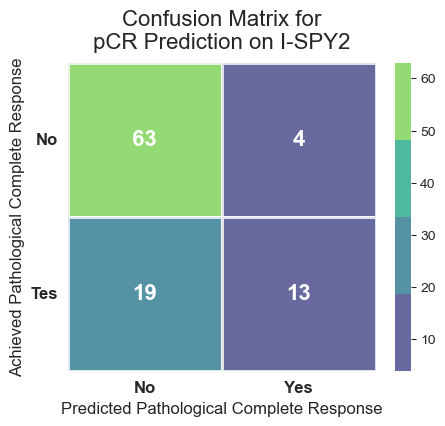

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set_style("white")  # or sns.set_style("ticks")



# Confusion matrix data
cm = np.array([[63, 4],   # True No:  63 correct, 4 false positives
               [19, 13]]) # True Yes: 19 false negatives, 13 correct

# Calculate metrics
total = cm.sum()
accuracy = (cm[0,0] + cm[1,1]) / total
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
f1_score = 2 * (precision * recall) / (precision + recall)

# Create the plot
plt.figure(figsize=(5,4))

# Use viridis colormap similar to your feature importance plot
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 4))

# Create custom colormap from the viridis colors to match bar plot style
from matplotlib.colors import ListedColormap
custom_viridis = ListedColormap(colors)

# Create heatmap with custom colors matching your bar plot
ax = sns.heatmap(cm,
                 annot=True,
                 fmt='d',
                 cmap=custom_viridis,
                 #cbar_kws={'label': 'Number of Samples'},
                 square=True,
                 linewidths=2,
                 linecolor='white',
                 annot_kws={'size': 16, 'weight': 'bold', 'color': 'white'},
                 alpha=0.8)

# Customize labels and title
plt.xlabel('Predicted Pathological Complete Response', fontsize=12)#, fontweight='bold')
plt.ylabel('Achieved Pathological Complete Response', fontsize=12)#, fontweight='bold')
plt.title('Confusion Matrix for\npCR Prediction on I-SPY2',
          fontsize=16, pad=10)

# Set tick labels
ax.set_xticklabels(['No', 'Yes'], fontsize=12, fontweight='bold')
ax.set_yticklabels(['No', 'Tes'], fontsize=12, fontweight='bold', rotation=0)



plt.show()


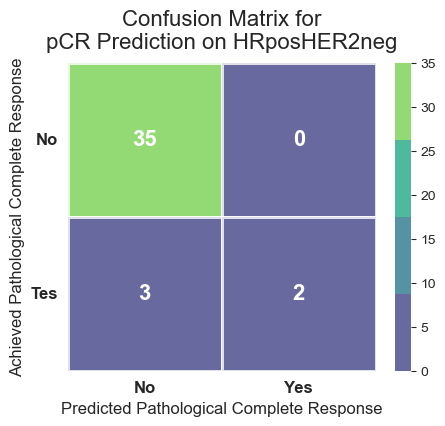

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set_style("white")  # or sns.set_style("ticks")



# Confusion matrix data
cm = np.array([[35, 0],   # True No:  63 correct, 4 false positives
               [3, 2]]) # True Yes: 19 false negatives, 13 correct

# Calculate metrics
total = cm.sum()
accuracy = (cm[0,0] + cm[1,1]) / total
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
f1_score = 2 * (precision * recall) / (precision + recall)

# Create the plot
plt.figure(figsize=(5,4))

# Use viridis colormap similar to your feature importance plot
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 4))

# Create custom colormap from the viridis colors to match bar plot style
from matplotlib.colors import ListedColormap
custom_viridis = ListedColormap(colors)

# Create heatmap with custom colors matching your bar plot
ax = sns.heatmap(cm,
                 annot=True,
                 fmt='d',
                 cmap=custom_viridis,
                 #cbar_kws={'label': 'Number of Samples'},
                 square=True,
                 linewidths=2,
                 linecolor='white',
                 annot_kws={'size': 16, 'weight': 'bold', 'color': 'white'},
                 alpha=0.8)

# Customize labels and title
plt.xlabel('Predicted Pathological Complete Response', fontsize=12)#, fontweight='bold')
plt.ylabel('Achieved Pathological Complete Response', fontsize=12)#, fontweight='bold')
plt.title('Confusion Matrix for\npCR Prediction on HRposHER2neg',
          fontsize=16, pad=10)

# Set tick labels
ax.set_xticklabels(['No', 'Yes'], fontsize=12, fontweight='bold')
ax.set_yticklabels(['No', 'Tes'], fontsize=12, fontweight='bold', rotation=0)



plt.show()
